In [1]:
# pip install -q langchain_tavily langgraph-checkpoint-postgres

In [1]:
import os
from typing import List, Dict, TypedDict
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from IPython.display import display, Markdown

In [2]:
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
DATABASE_URL = os.getenv("DATABASE_URL")

llm = ChatOpenAI(model="gpt-4o")
tavily= TavilySearch(max_results=2,
                     topic="general",
                     # include_answer=False,
                     # include_raw_content=False,
                     # include_images=False,
                     # include_image_descriptions=False,
                     # search_depth="basic",
                     # time_range="day",
                     # include_domains=None,
                     # exclude_domains=None
                    )

In [3]:
pip install psycopg-binary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: C:\Users\saraw\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
pip show psycopg psycopg2-binary

Name: psycopg
Version: 3.2.6
Summary: PostgreSQL database adapter for Python
Home-page: https://psycopg.org/psycopg3/
Author: Daniele Varrazzo
Author-email: daniele.varrazzo@gmail.com
License: GNU Lesser General Public License v3 (LGPLv3)
Location: C:\Users\saraw\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: typing-extensions, tzdata
Required-by: langgraph-checkpoint-postgres
---
Name: psycopg2-binary
Version: 2.9.10
Summary: psycopg2 - Python-PostgreSQL Database Adapter
Home-page: https://psycopg.org/
Author: Federico Di Gregorio
Author-email: fog@initd.org
License: LGPL with exceptions
Location: C:\Users\saraw\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: 
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
from langgraph.checkpoint.postgres import PostgresSaver

from psycopg_pool import ConnectionPool

connection_kwargs = {
    "autocommit": True,
    "prepare_threshold": 0,
}

pool = ConnectionPool(
    conninfo=DATABASE_URL,
    min_size=1,  # Ensure at least one connection is available
    max_size=10, # Prevent connection exhaustion
    kwargs=connection_kwargs,
)

checkpointer = PostgresSaver(pool)
checkpointer.setup()

In [6]:
HYPOTHESIS_PROMPT = "Based on the description: '{description}', list possible 3 skin diseases."

RESEARCH_PLAN_PROMPT = "Generate a research plan to gather information about the following skin diseases: {diseases}. Focus on symptoms, causes, and diagnostic criteria."

QUESTION_SELECTOR_PROMPT = "Based on the research findings and current hypotheses, generate a simple, relevant question to ask the user to refine the diagnosis. Avoid repeating questions from the conversation history."

HYPOTHESIS_UPDATE_PROMPT = "Update the list of possible skin diseases with probabilities (as decimals between 0 and 1) based on the initial description and conversation history."

In [7]:
class State(TypedDict):
    conversation_history: List[BaseMessage]
    current_hypotheses: List[tuple[str, float]]
    research_findings: Dict[str, str]
    research_queries: List[str]
    user_responses: List[str]
    iteration_count: int
    input_description: str
    confident: bool
    current_question: str
    final_ans: str

In [8]:
# initial_state = {
#     "conversation_history": [],
#     "current_hypotheses": [],
#     "research_findings": {},
#     "research_queries": [],
#     "user_responses": [],
#     "iteration_count": 0,
#     "input_description": "I have a red, itchy rash on my arm.",
#     "confident": False,
#     "current_question": ""
# }

In [10]:
def input_processor(state: State) -> State:
    """Processes initial user input if not already provided."""
    if not state['input_description']:
        user_input = input("Please describe your skin condition: ")
        state['input_description'] = user_input
        state['conversation_history'].append(HumanMessage(content=user_input))
    else:
        state['conversation_history'].append(HumanMessage(content=state['input_description']))
    return state

In [11]:
# input_processor(initial_state)

# initial_state

In [12]:
def hypothesis_generator(state: State) -> State:
    """Generates initial disease hypotheses."""
    prompt = HYPOTHESIS_PROMPT.format(description=state['input_description'])
    response = llm.invoke([SystemMessage(content="You are a dermatology assistant."), 
                          HumanMessage(content=prompt)])
    diseases = [d.strip() for d in response.content.split('\n') if d.strip()]
    state['current_hypotheses'] = [(disease, 1.0 / len(diseases)) for disease in diseases]
    return state

In [13]:
# hypothesis_generator(initial_state)

# initial_state['current_hypotheses']

In [14]:
# def research_planner(state: State) -> State:
#     """Plans research using AI."""
#     diseases = ', '.join([disease for disease, _ in state['current_hypotheses']])
#     prompt = RESEARCH_PLAN_PROMPT.format(diseases=diseases)
#     response = llm.invoke([SystemMessage(content="You are a dermatology research assistant."), 
#                           HumanMessage(content=prompt)])
#     queries = [q.strip() for q in response.content.split('\n') if q.strip()]
#     state['research_queries'] = queries
#     return state

def research_planner(state: State) -> State:
    """Plans internet research by generating searchable queries based on hypotheses."""
    hypotheses = [disease for disease, _ in state['current_hypotheses']]
    queries = []
    for disease in hypotheses:
        queries.append(f"common symptoms of {disease} skin condition")
        queries.append(f"causes of {disease} dermatology")
        queries.append(f"diagnostic criteria for {disease} skin disease")
    state['research_queries'] = queries
    return state

In [15]:
# research_planner(initial_state)

# initial_state['research_queries']

In [16]:
def internet_researcher(state: State) -> State:
    """Conducts internet research."""
    findings = {}
    for query in state['research_queries']:
        results = tavily.invoke({"query": query})
        findings[query] = results['results'][0]['content']
    state['research_findings'].update(findings)
    return state

In [17]:
# internet_researcher(initial_state)
# initial_state['research_findings']

In [18]:
def question_selector(state: State) -> State:
    """Selects a simple question using AI."""
    history_text = "\n".join([f"{msg.type}: {msg.content}" for msg in state['conversation_history']])
    findings_text = "\n".join([f"{q}: {f}" for q, f in state['research_findings'].items()])
    prompt = QUESTION_SELECTOR_PROMPT + f"\n\nResearch Findings:\n{findings_text}\n\nConversation History:\n{history_text}"
    response = llm.invoke([SystemMessage(content="You are a dermatology assistant."), 
                          HumanMessage(content=prompt)])
    state['current_question'] = response.content.strip()
    return state

In [19]:
# question_selector(initial_state)
# initial_state['current_question']

In [20]:
# def user_interactor(state: State) -> State:
#     """Interacts with the user."""
#     # print(f"Question: {state['current_question']}")
#     # response = input("Your answer (yes/no or brief description): ")
#     response = state['user_responses']
#     state['conversation_history'].append(AIMessage(content=state['current_question']))
#     state['conversation_history'].append(HumanMessage(content=response))
#     # state['user_responses'].append(response)
#     return state

In [21]:
# user_interactor(initial_state)

In [22]:
def hypothesis_updater(state: State) -> State:
    """Updates hypotheses based on history."""
    history_text = "\n".join([f"{msg.type}: {msg.content}" for msg in state['conversation_history']])
    prompt = HYPOTHESIS_UPDATE_PROMPT + f"\n\nInitial Description: {state['input_description']}\n\nConversation History:\n{history_text}"
    response = llm.invoke([SystemMessage(content="You are a dermatology assistant."), 
                          HumanMessage(content=prompt)])
    lines = response.content.split('\n')
    updated_hypotheses = []
    for line in lines:
        if ':' in line:
            parts = line.split(':')
            if len(parts) == 2:
                disease, prob = parts
                try:
                    updated_hypotheses.append((disease.strip(), float(prob.strip())))
                except ValueError:
                    continue
    state['current_hypotheses'] = updated_hypotheses if updated_hypotheses else state['current_hypotheses']
    return state

In [23]:
# hypothesis_updater(initial_state)

In [24]:
def confidence_checker(state: State) -> State:
    """Checks confidence level."""
    state['iteration_count'] += 1
    if state['current_hypotheses']:
        top_prob = max(prob for _, prob in state['current_hypotheses'])
        if top_prob > 0.9 or state['iteration_count'] >= 3:
            state['confident'] = True
    return state

In [25]:
# confidence_checker(initial_state)

In [26]:
def final_output_provider(state: State) -> State:
    """Provides the final diagnosis."""
    if state['current_hypotheses']:
        top_disease, top_prob = max(state['current_hypotheses'], key=lambda x: x[1])
        state['final_ans'] = f"Diagnosis: {top_disease} with {top_prob*100:.2f}% confidence."
    else:
        print("Unable to determine a diagnosis.")
    return state

In [27]:
graph = StateGraph(State)

graph.add_node("input_processor", input_processor)
graph.add_node("hypothesis_generator", hypothesis_generator)
graph.add_node("research_planner", research_planner)
graph.add_node("internet_researcher", internet_researcher)
graph.add_node("question_selector", question_selector)
graph.add_node("hypothesis_updater", hypothesis_updater)
graph.add_node("confidence_checker", confidence_checker)
graph.add_node("final_output_provider", final_output_provider)

In [28]:
graph.add_edge("input_processor", "hypothesis_generator")
graph.add_edge("hypothesis_generator", "research_planner")
graph.add_edge("research_planner", "internet_researcher")
graph.add_edge("internet_researcher", "question_selector")
graph.add_edge("question_selector", "hypothesis_updater")
graph.add_edge("hypothesis_updater", "confidence_checker")

In [29]:
def route_confidence(state: State) -> str:
    return "final_output_provider" if state['confident'] else "research_planner"

graph.add_conditional_edges("confidence_checker", route_confidence, 
                            {"final_output_provider": "final_output_provider", 
                             "research_planner": "research_planner"})
graph.add_edge("final_output_provider", END)

graph.set_entry_point("input_processor")

app = graph.compile(checkpointer=checkpointer, interrupt_before=["hypothesis_updater"])

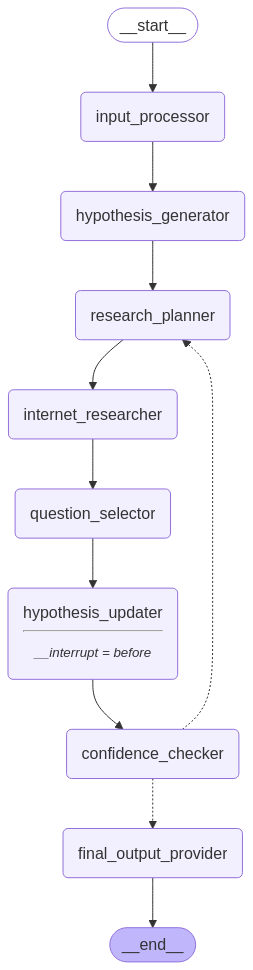

In [30]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ),
    )
)

In [31]:
initial_state = {
    "conversation_history": [],
    "current_hypotheses": [],
    "research_findings": {},
    "research_queries": [],
    "user_responses": "",
    "iteration_count": 0,
    "input_description": "I have a red, itchy rash on my arm.",
    "confident": False,
    "current_question": "",
    "final_ans":""
}
thread = {"configurable": {"thread_id": "15"}}
result_states = []

In [32]:
result = app.invoke(initial_state, thread)

In [33]:
result['current_hypotheses']

[('Based on the description of a red, itchy rash on the arm, here are three possible skin conditions:',
  0.2),
 ('1. **Contact Dermatitis**: This is a common skin reaction that can occur when the skin comes into contact with an allergen or irritant, such as certain soaps, plants (like poison ivy), or fabrics. It often results in a red, itchy rash.',
  0.2),
 ('2. **Eczema (Atopic Dermatitis)**: Eczema is a chronic condition that causes inflamed, itchy, and sometimes blistered skin. It often appears on the arms and can be triggered by environmental factors or stress.',
  0.2),
 ('3. **Psoriasis**: This is an autoimmune condition that leads to the rapid growth of skin cells, resulting in thick, red patches covered with silvery scales. While psoriasis can appear anywhere on the body, it often affects the arms, particularly the elbows.',
  0.2),
 ('It is advisable to seek a professional evaluation from a dermatologist for an accurate diagnosis and appropriate treatment.',
  0.2)]

In [41]:
state = app.get_state(thread)
state.next()

TypeError: 'tuple' object is not callable

In [40]:
if state.values:
    print("hi")

In [37]:
if state.values and state.values['final_ans']:
    print("hi")

In [53]:
app.update_state(state.config, values = {"final_ans": "hi"})

{'configurable': {'thread_id': '10',
  'checkpoint_ns': '',
  'checkpoint_id': '1f015e07-6de0-6c68-800d-a2b0e948d706'}}

In [56]:
state.values['final_ans']

'hi'

In [50]:
state.config

{'configurable': {'thread_id': '10',
  'checkpoint_ns': '',
  'checkpoint_id': '1f015df8-8456-6052-800c-3909431a4f3a'}}

In [38]:
state.values['final_ans'] = "Hello"

# checkpointer.save_state(thread, state)

In [34]:
if not state.next:
    print("hi")

hi


In [38]:
state = app.get_state(thread)

In [39]:
state.next

('hypothesis_updater',)

In [43]:
state = app.get_state(thread)
if state.next[0] == 'hypothesis_updater':
    print(state.values['current_question'])

    input_text = input("")
    initial_state['user_responses'] = input_text
    
    result = app.invoke(initial_state, thread)

Did your rash appear suddenly, and have you been in contact with any new products, such as soaps, lotions, or plants recently?


 no


In [45]:
state = app.get_state(thread)

state.next

('hypothesis_updater',)

In [40]:
state = app.get_state(thread)
if state.next[0] == 'hypothesis_updater':
    print(state.values['current_question'])

    input_text = input("")
    initial_state['user_responses'] = input_text
    
    for s in app.stream(initial_state, thread):
        result_states.append(s)

Have you recently started using any new products on your skin, like lotions, soaps, or detergents, that could have come into contact with the area of the rash?


 No
